# Food Classification
For this work i use the food image dataset. My attemp was to classify 14 types of food. 
The original dataset contains a number of different subsets of the full food-101 data. Each class have 1000 images. I extract 14 subsets of images of this dataset. The Original dataset can be found in this link https://www.kaggle.com/kmader/food41.


If you want to explore the fail attemps and other resources go to https://github.com/David9203/U3project


Firts you have download the db, with the next cell

In [1]:
!wget -nc https://www.dropbox.com/s/6dxg6qi6v56umge/project.zip?dl=0
!unzip project.zip?dl=0
!wget -nc https://www.dropbox.com/s/bzfhlrih4cbq1wf/Archive.zip?dl=0
!unzip Archive.zip?dl=0

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: project/amoestadb/guacamole/99890.jpg  
  inflating: project/amoestadb/guacamole/2646371.jpg  
  inflating: project/amoestadb/guacamole/75638.jpg  
  inflating: project/amoestadb/guacamole/907331.jpg  
  inflating: project/amoestadb/guacamole/2945758.jpg  
  inflating: project/amoestadb/guacamole/842817.jpg  
  inflating: project/amoestadb/guacamole/3244541.jpg  
  inflating: project/amoestadb/guacamole/715426.jpg  
  inflating: project/amoestadb/guacamole/826427.jpg  
  inflating: project/amoestadb/guacamole/961915.jpg  
  inflating: project/amoestadb/guacamole/3655154.jpg  
  inflating: project/amoestadb/guacamole/2969754.jpg  
  inflating: project/amoestadb/guacamole/694024.jpg  
  inflating: project/amoestadb/guacamole/675996.jpg  
  inflating: project/amoestadb/guacamole/76061.jpg  
  inflating: project/amoestadb/guacamole/3262236.jpg  
  inflating: project/amoestadb/guacamole/717801.jpg  
  inflating:

In [0]:
rm Archive.zip?dl\=0

In [0]:
rm project.zip?dl=0


Example of the images

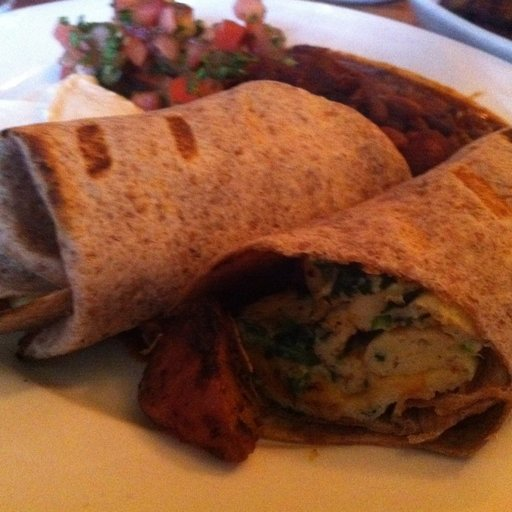

In [6]:
from IPython.display import Image
Image(filename='/content/project/amoestadb/breakfast_burrito/1000351.jpg',width="400")

In [7]:

from keras import optimizers
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


In [0]:
model_final = tf.keras.models.load_model('modelfinal')

In [8]:
%cd project

/content/project


The below are the classes to classify 

breakfast_burrito/  donuts/         guacamole/        seaweed_salad/
chicken_wings/      edamame/        hamburger/        spaghetti_bolognese/
churros/            french_fries/   red_velvet_cake/
cup_cakes/          frozen_yogurt/  sashimi/

#Attemps 
The next table show the attemps that i try, **Firts** i try with a network constructed by myself but i get an lower accuracy (0.55).
Next i decide to apply the methodology of transfer learning. I try with Resnet50 (0.59) and then i try with the networks that i show in the table.  

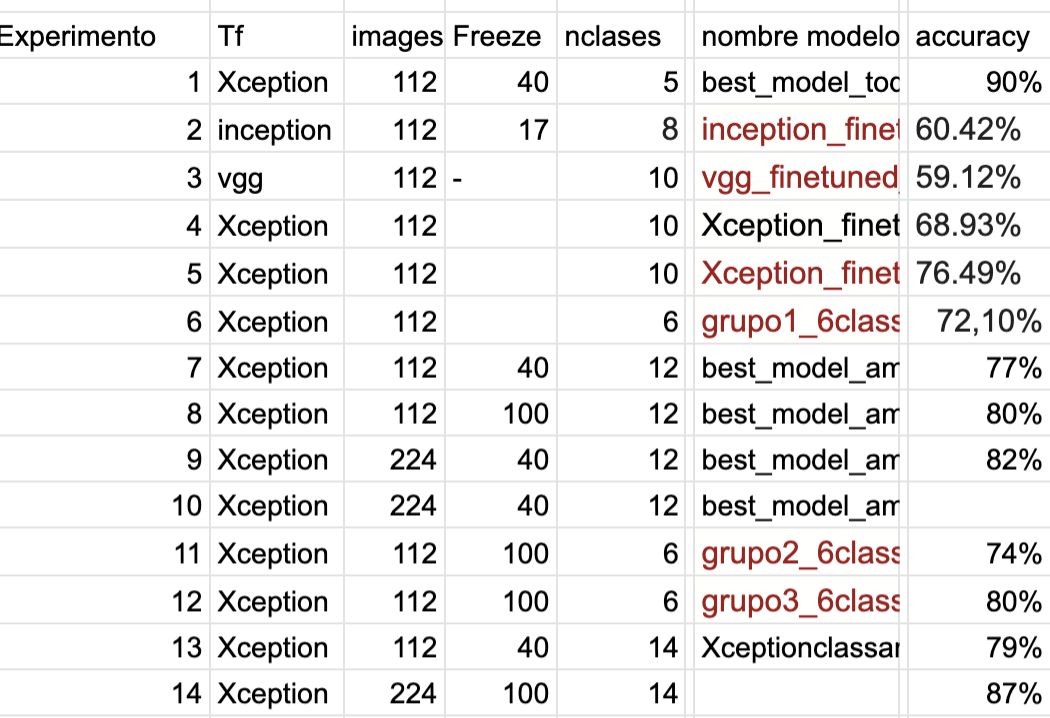

In [0]:
Image(filename='experiments.png',width="700")


as we see i start applying vgg and inception, nex i found this table 

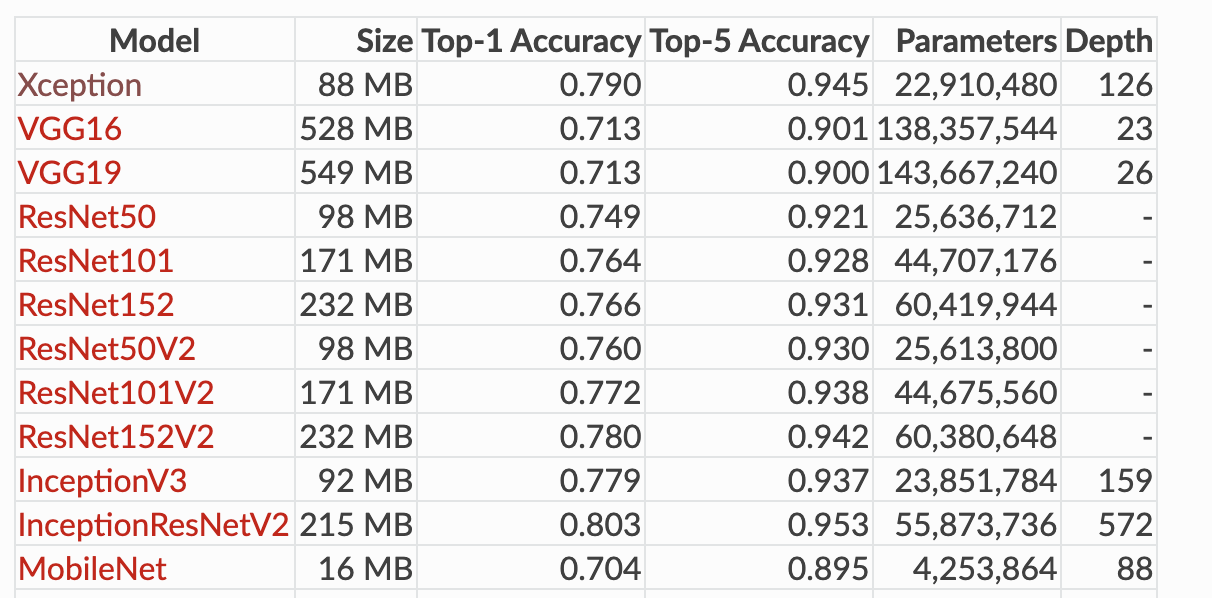

In [0]:
Image(filename='trans.png',width="600")

I made a cleaning of the images becouse there are some that was noisy as its show in the next figure

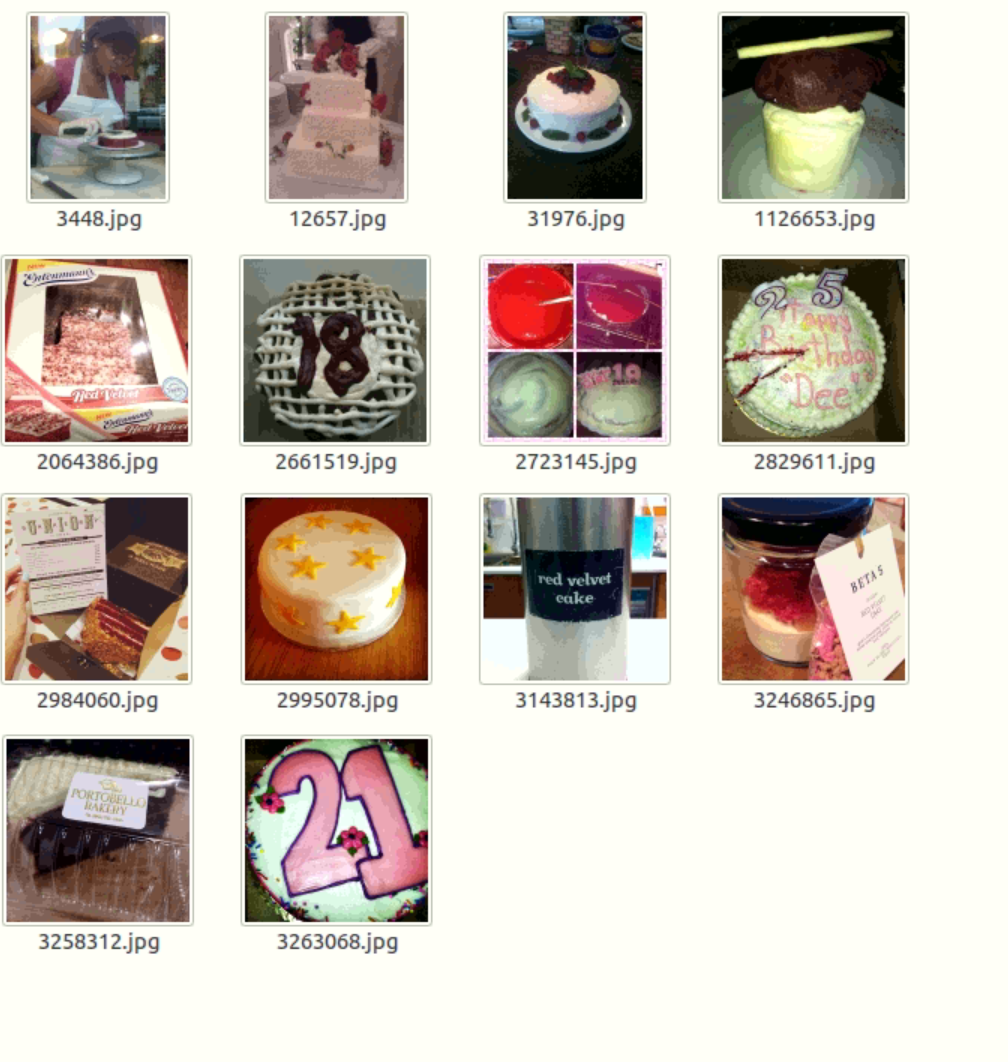

In [0]:
Image(filename='fake.png',width="1000")

So i delete the images that doesnt aport information for my model.

# parameters  to train the network

In [0]:
TEST_SPLIT = 0.25
epochs = 80
#batch_size = 16
batch_size=32
IMG_SIZE = (224, 224)
LEARNING_RATE = 0.001
seed=1

# Training with ImageDataGenerator

The data loading is implemented through the Keras ImageDataGenerator, this avoids loading the images in their entirety and only the images used by each batch in the training are loaded. for the img size i decided to train with 224 becouse the images have good resolution. We use split-folders to create a set of test

In [9]:
pip install split-folders


In [0]:
import split_folders

In [11]:
split_folders.ratio('amoestadb', output="output", seed=1337, ratio=(.9, .1)) # default values

Copying files: 13739 files [00:03, 4265.48 files/s]


In [0]:
train_data_dir='output/train'
val_data_dir='output/val'

In [15]:


class Generators:
    """
    Train, validation and test generators

    
    """
    def __init__(self):
        self.batch_size=32
        self.img_size=IMG_SIZE
        
        # Base train/validation generator
        _datagen = ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.2,
            
            )
        # Train generator
        self.train_generator = _datagen.flow_from_directory(
            
            directory=train_data_dir,
            
            
            subset="training",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)
        print('Train generator created')
        # Validation generator
        self.val_generator = _datagen.flow_from_directory(
            
            directory=train_data_dir,
           
           
            subset="validation",
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=self.img_size)    
        print('Validation generator created')
        # Test generator
        _test_datagen=ImageDataGenerator(rescale=1./255.)
        self.test_generator = _test_datagen.flow_from_directory(
            directory=val_data_dir,
            class_mode="categorical",
            batch_size=self.batch_size,
            seed=42,
            shuffle=False,
            target_size=self.img_size)     
        print('Test generator created')
        
# Create generators        
generators = Generators()
print("Generators created")

Found 9894 images belonging to 14 classes.
Train generator created
Found 2465 images belonging to 14 classes.
Validation generator created
Found 1380 images belonging to 14 classes.
Test generator created
Generators created


I decide to freeze 100 layers and include others with regularization and ad a dropout of 0.4, the model are save in best_model_amodb14classes224.hdf5

In [16]:
from keras import applications
model = applications.Xception(weights='imagenet', 
                                include_top=False, input_shape = (224,224,3))


len(model.layers)

for layer in model.layers[:100]:
    layer.trainable = False
regparameter=0.0001

x = model.output
x = Flatten()(x)
x = Dense(256, activation="relu",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=regparameter,l2=regparameter))(x)
x = Dropout(0.4)(x)
x = Dense(4096, activation="relu")(x)
predictions = Dense(14, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
model_final.summary()







83689472/83683744 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [0]:
model_final.load_weights('/content/best_model_amodb12classes224.hdf5')

If you want to train the model run the next cell, if not ignore the cell

In [0]:
from tensorflow import keras


chkpt = ModelCheckpoint(filepath='best_model_amodb12classes224.hdf5', save_best_only=True, save_weights_only=True)


model_final.fit_generator(
    generators.train_generator,
    steps_per_epoch = generators.train_generator.samples // batch_size,
    validation_data = generators.val_generator, 
    validation_steps = generators.val_generator.samples // batch_size,
    epochs = 5,callbacks=[chkpt])

In [0]:
model_final.save('modelfinal')

The performance for the test give us 87% and for validation 93%





In [18]:
model_final.evaluate_generator(generators.test_generator)

[0.5136507749557495, 0.9340579509735107]

In [19]:
model_final.metrics_names

['loss', 'accuracy']

In [0]:
prob=model_final.predict_generator(generators.test_generator)

In [0]:


import numpy as np
ypred=np.argmax(prob,axis=1)
y_true=generators.test_generator.classes


In [0]:
classes=generators.test_generator.class_indices

In [23]:
import numpy as np 
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true, ypred, average='macro')

(0.9350004033220974, 0.9341333124158755, 0.9336401407208077, None)

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, ypred)


0.9340579710144927

In [0]:
cf=tf.math.confusion_matrix(y_true,ypred)

In [0]:
cff=cf.numpy()

In [0]:
listdir=classes

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


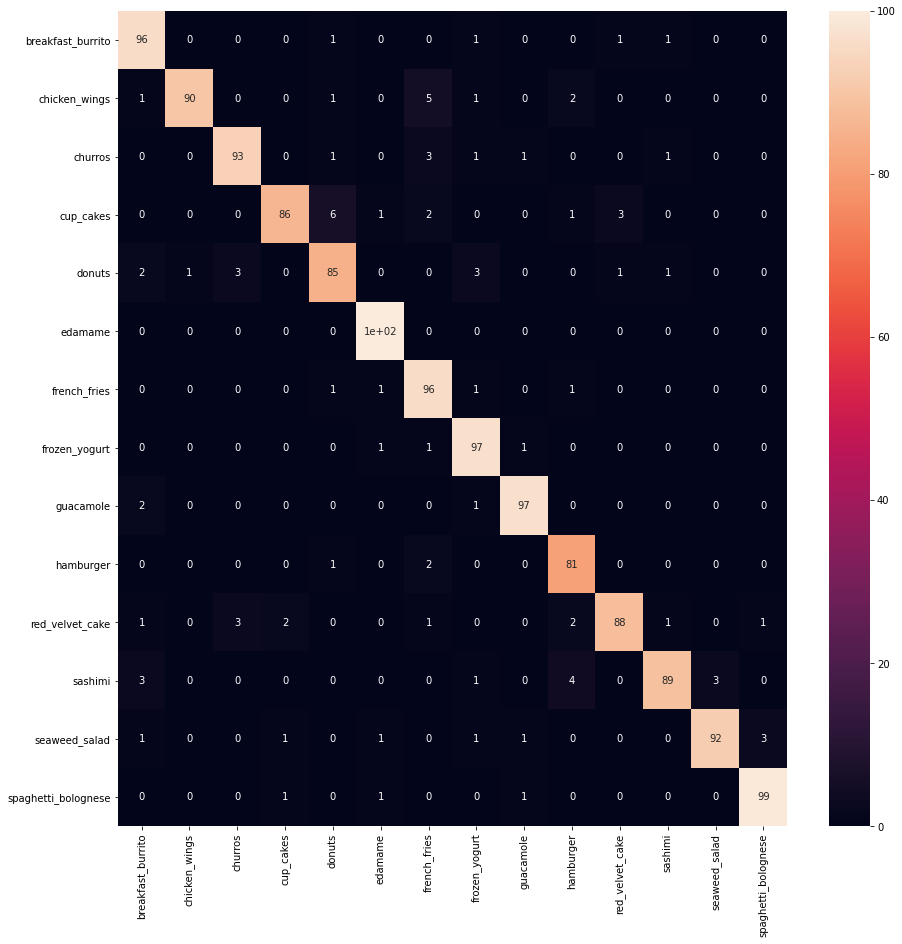

In [28]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cff, index = [i for i in listdir],
                  columns = [i for i in listdir])
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True)